In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
# import gseapy as gp
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand
import cerberus

p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from proc_revisions.utils import *
from proc_revisions.plotting import *


In [2]:
od = '../../proc_revisions/'
config_file = f'{od}/config.yml'
with open(config_file) as f:
    config = yaml.safe_load(f)

In [43]:
ab = od+expand(config['lr']['talon']['fusion_fix']['ab'], species='human')[0]
filt_ab = od+expand(config['lr']['cerberus']['filt_ab'], species='human')[0]
read_annot = od+expand(config['lr']['talon']['full_annot'], species='human')[0]
t_metadata = od+expand(config['ref']['cerberus']['new_gtf_t_info'], species='human')[0]
lib_meta = od+expand(config['lr']['meta'], species='human')[0]
swan_file = od+expand(config['lr']['swan']['sg'], species='human')[0]
cerberus_h5 = od+expand(config['lr']['cerberus']['ca_triplets'], species='human', obs_col='sample')[0]
cerb_t_metadata = od+expand(config['lr']['cerberus']['gtf_t_info'], species='human')[0]
major_isos = od+expand(config['lr']['analysis']['major_isos'], species='human', obs_col='sample')[0]
pi_tpm_table = od+expand(config['lr']['mane']['pi_tpm']['triplet'], species='human', obs_col='sample')[0]
pp_summary = od+expand(config['lr']['protein_pred']['summary'], species='human')[0]

ref_t_metadata = od+expand(config['ref']['new_gtf_t_info'], species='human')[0]
ref_g_metadata = od+expand(config['ref']['new_gtf_g_info'], species='human')[0]

sr_ab = '../'+config['sr']['ab']


ver = 'v40_cerberus'
min_tpm = 1
gene_subset = 'protein_coding'
obs_col = 'sample'
go_gene_subset = 'protein_coding'

m_ab = od+expand(config['lr']['talon']['fusion_fix']['ab'], species='mouse')[0]
m_filt_ab = od+expand(config['lr']['cerberus']['filt_ab'], species='mouse')[0]
m_read_annot = od+expand(config['lr']['talon']['full_annot'], species='mouse')[0]
m_t_metadata = od+expand(config['ref']['cerberus']['new_gtf_t_info'], species='mouse')[0]
m_lib_meta = od+expand(config['lr']['meta'], species='mouse')[0]
m_swan_file = od+expand(config['lr']['swan']['sg'], species='mouse')[0]
m_cerberus_h5 = od+expand(config['lr']['cerberus']['ca_triplets'], species='mouse', obs_col='sample')[0]
cerb_t_metadata = od+expand(config['lr']['cerberus']['gtf_t_info'], species='mouse')[0]
m_major_isos = od+expand(config['lr']['analysis']['major_isos'], species='mouse', obs_col='sample')[0]
m_pi_tpm_table = od+expand(config['lr']['mane']['pi_tpm']['triplet'], species='mouse', obs_col='sample')[0]
m_pp_summary = od+expand(config['lr']['protein_pred']['summary'], species='mouse')[0]
human_mouse_sect_cons = '../fig5/human_mouse_sect_cons.tsv'


m_ref_t_metadata = od+expand(config['ref']['new_gtf_t_info'], species='mouse')[0]
m_ref_g_metadata = od+expand(config['ref']['new_gtf_g_info'], species='mouse')[0]


orth_table = '../../proc_revisions/ref/biomart_human_to_mouse.tsv'


m_ver = 'vM25_cerberus'

## Mouse

In [4]:
min_samples = 6

In [5]:
ca = cerberus.read(m_cerberus_h5)

In [6]:
df = ca.triplets.copy(deep=True)

In [7]:
# limit to sample_det
df = ca.triplets.copy(deep=True)
df = df.loc[df.source=='sample_det']

# for each gene, compute the mode sector
temp = df[['gid', 'sector']].groupby('gid').agg(lambda x: st.mode(x)[0]).reset_index().rename({'sector':'mode_sector'}, axis=1)
df = df.merge(temp, how='left', on='gid')

# which samples have the same sector as mode?
df['same_as_mode'] = df.sector==df.mode_sector
df.head()

# what % of samples / gene have the same sector?
temp = df[['gid', 'same_as_mode', 'mode_sector', 'sample']].groupby(['gid', 'same_as_mode', 'mode_sector']).count().reset_index().rename({'sample':'n_samples'}, axis=1)
temp2 = df[['gid', 'sample']].groupby('gid').count().reset_index().rename({'sample':'n_tot_samples'}, axis=1)
temp = temp.merge(temp2, how='left', on='gid')

# remove things that are only expressed in a few samples
temp = temp.loc[temp.n_tot_samples >= min_samples]
temp['perc'] = (temp.n_samples/temp.n_tot_samples)*100

# remove things that are all simple
temp = temp.loc[temp.mode_sector != 'simple']

# now get the 2nd mode
temp2 = df.loc[df.same_as_mode==False]
temp2 = temp2[['gid', 'sector']].groupby('gid').agg(lambda x: st.mode(x)[0]).reset_index().rename({'sector':'mode_sector_2'}, axis=1)
temp = temp.merge(temp2, 
                  on='gid',
                  how='left')

# add biotype info
gene_df, _, _ = get_gtf_info(ver=m_ver, how='gene', add_stable_gid=True)
temp = temp.merge(gene_df[['gid_stable',
                      'gname',
                      'biotype_category']].rename({'gid_stable':'gid'}, axis=1),
                      how='left', on='gid')

In [8]:
temp.head()

,gid,same_as_mode,mode_sector,n_samples,n_tot_samples,perc,mode_sector_2,gname,biotype_category
0,ENSMUSG00000000028,False,mixed,12,32,37.500000,tss,Cdc45,protein_coding
1,ENSMUSG00000000028,True,mixed,20,32,62.500000,tss,Cdc45,protein_coding
2,ENSMUSG00000000031,False,tss,11,24,45.833333,mixed,H19,lncRNA
3,ENSMUSG00000000031,True,tss,13,24,54.166667,mixed,H19,lncRNA
4,ENSMUSG00000000049,False,mixed,4,8,50.000000,simple,Apoh,protein_coding


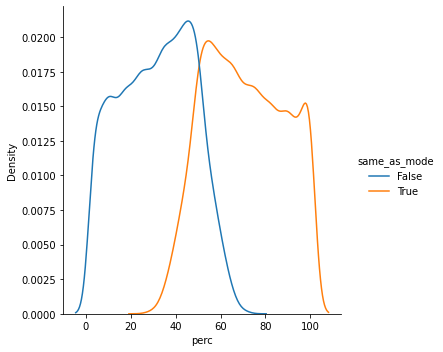

In [9]:
ax = sns.displot(temp, 
                 x='perc',
                 hue='same_as_mode',
                 common_norm=False,
                 kind='kde')
                 

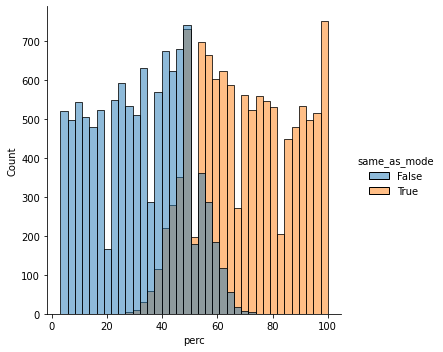

In [10]:
ax = sns.displot(temp, 
                 x='perc',
                 hue='same_as_mode')

In [11]:
temp.head()

,gid,same_as_mode,mode_sector,n_samples,n_tot_samples,perc,mode_sector_2,gname,biotype_category
0,ENSMUSG00000000028,False,mixed,12,32,37.500000,tss,Cdc45,protein_coding
1,ENSMUSG00000000028,True,mixed,20,32,62.500000,tss,Cdc45,protein_coding
2,ENSMUSG00000000031,False,tss,11,24,45.833333,mixed,H19,lncRNA
3,ENSMUSG00000000031,True,tss,13,24,54.166667,mixed,H19,lncRNA
4,ENSMUSG00000000049,False,mixed,4,8,50.000000,simple,Apoh,protein_coding


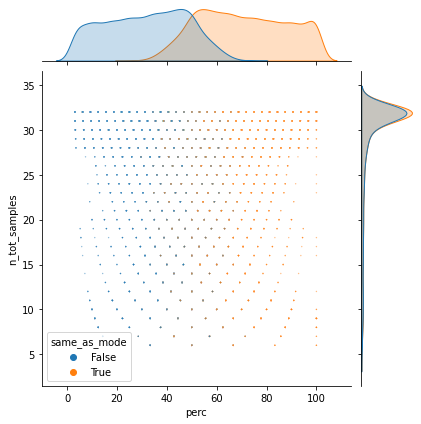

In [12]:
ax = sns.jointplot(temp,
                   x='perc',
                   y='n_tot_samples',
                   hue='same_as_mode',
                   joint_kws={'s':2,
                              'alpha':0.5})

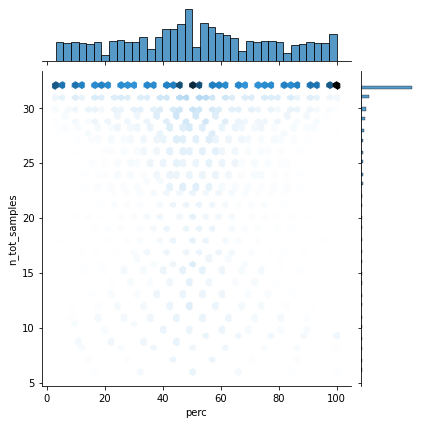

In [13]:
temp2 = temp.loc[temp.same_as_mode==True] 
ax = sns.jointplot(temp,
                   x='perc',
                   y='n_tot_samples',
                   kind='hex')

In [14]:
# look at max. number of isoforms
temp2 = df[['gid', 'n_iso']].groupby('gid').max().rename({'n_iso':'max_n_iso'}, axis=1).reset_index()
temp = temp.merge(temp2, 
                  how='left',
                  on='gid')
temp.head()

,gid,same_as_mode,mode_sector,n_samples,n_tot_samples,perc,mode_sector_2,gname,biotype_category,max_n_iso
0,ENSMUSG00000000028,False,mixed,12,32,37.500000,tss,Cdc45,protein_coding,6.0
1,ENSMUSG00000000028,True,mixed,20,32,62.500000,tss,Cdc45,protein_coding,6.0
2,ENSMUSG00000000031,False,tss,11,24,45.833333,mixed,H19,lncRNA,12.0
3,ENSMUSG00000000031,True,tss,13,24,54.166667,mixed,H19,lncRNA,12.0
4,ENSMUSG00000000049,False,mixed,4,8,50.000000,simple,Apoh,protein_coding,2.0


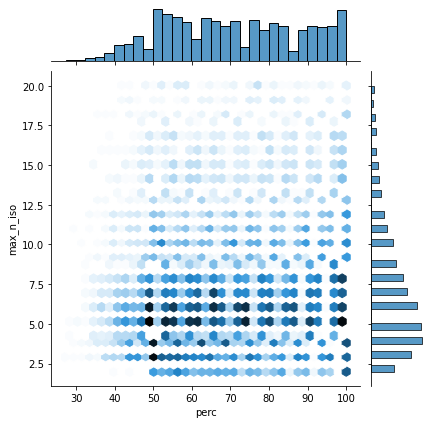

In [15]:
temp2 = temp.loc[temp.same_as_mode==True] 
temp2 = temp2.loc[temp2.max_n_iso<=20]
ax = sns.jointplot(temp2,
                   x='perc',
                   y='max_n_iso',
                   kind='hex')

In [16]:
temp.loc[temp.max_n_iso == 1]

,gid,same_as_mode,mode_sector,n_samples,n_tot_samples,perc,mode_sector_2,gname,biotype_category,max_n_iso


## What sectors are the most sample-conserved vs. least?

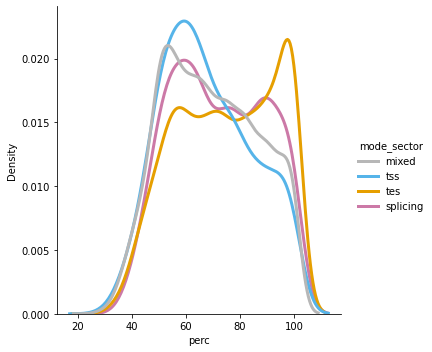

In [17]:
temp2 = temp.loc[temp.same_as_mode == True]
c_dict, order = get_sector_colors()
ax = sns.displot(temp2, 
                 x='perc',
                 hue='mode_sector',
                 palette=c_dict,
                 kind='kde',
                 linewidth=3,
                 common_norm=False)

## What % of these genes have "conserved" behavior across samples?

In [18]:
min_perc = 80

n = len(temp.gid.unique().tolist())
n_num = len(temp.loc[(temp.same_as_mode==True)&(temp.perc>=min_perc)].index)
print(f'{(n_num/n)*100:.2f}% ({n_num}/{n}) genes have >={min_perc}% of expressed samples in the same sector as the mode')

33.91% (3933/11600) genes have >=80% of expressed samples in the same sector as the mode


## What % of these genes have "conserved" behavior across samples; by mode sector

In [19]:
min_perc = 80

for s in temp.mode_sector.unique().tolist():
    temp2 = temp.loc[temp.mode_sector==s]
    n = len(temp2.gid.unique().tolist())
    n_num = len(temp2.loc[(temp2.same_as_mode==True)&(temp2.perc>=min_perc)].index)
    print(f'{(n_num/n)*100:.2f}% ({n_num}/{n}) genes have >={min_perc}% of expressed samples in the same {s} sector as the mode')

30.60% (2031/6637) genes have >=80% of expressed samples in the same mixed sector as the mode
25.96% (249/959) genes have >=80% of expressed samples in the same tss sector as the mode
43.94% (1189/2706) genes have >=80% of expressed samples in the same tes sector as the mode
35.75% (464/1298) genes have >=80% of expressed samples in the same splicing sector as the mode


## What are common mode-2nd mode pairings?

In [20]:
temp2 = temp[['gid', 'mode_sector', 'mode_sector_2']].groupby(['mode_sector', 'mode_sector_2']).count().reset_index().rename({'gid':'n_genes'}, axis=1)
off_list = ['mixed', 'simple']
temp2.loc[~(temp2.mode_sector.isin(off_list))&\
          ~(temp2.mode_sector_2.isin(off_list))]

,mode_sector,mode_sector_2,n_genes
8,tes,splicing,2
9,tes,tss,10
12,tss,tes,14


In [21]:
temp.loc[(temp.mode_sector=='tes')&\
         (temp.mode_sector_2=='tss')]

,gid,same_as_mode,mode_sector,n_samples,n_tot_samples,perc,mode_sector_2,gname,biotype_category,max_n_iso
4194,ENSMUSG00000021549,False,tes,3,32,9.375000,tss,Rasa1,protein_coding,10.0
4195,ENSMUSG00000021549,True,tes,29,32,90.625000,tss,Rasa1,protein_coding,10.0
5770,ENSMUSG00000024240,False,tes,19,32,59.375000,tss,Epc1,protein_coding,9.0
5771,ENSMUSG00000024240,True,tes,13,32,40.625000,tss,Epc1,protein_coding,9.0
7006,ENSMUSG00000026042,False,tes,17,30,56.666667,tss,Col5a2,protein_coding,12.0
7007,ENSMUSG00000026042,True,tes,13,30,43.333333,tss,Col5a2,protein_coding,12.0
17438,ENSMUSG00000048482,False,tes,18,28,64.285714,tss,Bdnf,protein_coding,22.0
17439,ENSMUSG00000048482,True,tes,10,28,35.714286,tss,Bdnf,protein_coding,22.0
18599,ENSMUSG00000054733,False,tes,18,32,56.250000,tss,Msra,protein_coding,8.0
18600,ENSMUSG00000054733,True,tes,14,32,43.750000,tss,Msra,protein_coding,8.0


## Plot a few examples

In [22]:
# first save
temp.to_csv('mouse_sample_sector_mode_cons.tsv', sep='\t', index=False)

In [23]:
ca = cerberus.read(m_cerberus_h5)

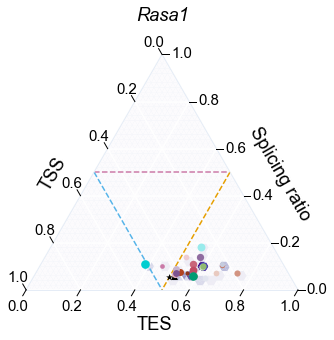

In [32]:
gene = 'Rasa1'
plot_sample_det_density_simplex(ca, gene, species='mouse')

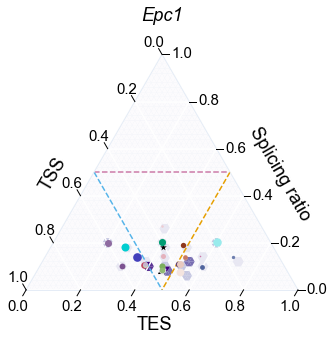

In [31]:
gene = 'Epc1'
plot_sample_det_density_simplex(ca, gene, species='mouse')

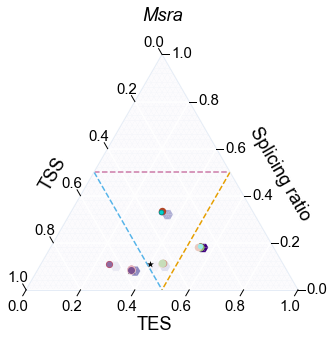

In [27]:
gene = 'Msra'
plot_sample_det_density_simplex(ca, gene, species='mouse')

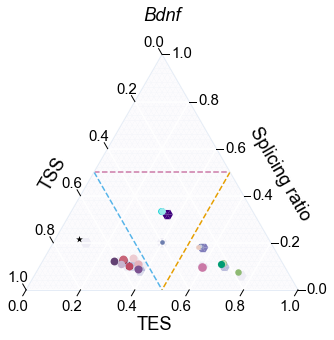

In [29]:
gene = 'Bdnf'
plot_sample_det_density_simplex(ca, gene, species='mouse')

In [30]:
ca.triplets.loc[(ca.triplets.gname==gene)&\
                (ca.triplets.source=='sample_det')].sort_values(by='sample')

,source,gid,n_tss,n_tes,n_ic,n_iso,splicing_ratio,tss_ratio,tes_ratio,spl_ratio,sector,gname,sample,gene_tpm
426262,sample_det,ENSMUSG00000048482,1.0,2.0,1.0,2.0,0.666667,0.272727,0.545455,0.181818,tes,Bdnf,adrenal_10d,1.009109
144762,sample_det,ENSMUSG00000048482,1.0,1.0,1.0,1.0,1.000000,0.333333,0.333333,0.333333,simple,Bdnf,adrenal_14d,0.252084
129000,sample_det,ENSMUSG00000048482,1.0,2.0,1.0,2.0,0.666667,0.272727,0.545455,0.181818,tes,Bdnf,adrenal_25d,0.581241
55557,sample_det,ENSMUSG00000048482,1.0,1.0,1.0,1.0,1.000000,0.333333,0.333333,0.333333,simple,Bdnf,adrenal_2mo,0.195724
85371,sample_det,ENSMUSG00000048482,1.0,2.0,1.0,2.0,0.666667,0.272727,0.545455,0.181818,tes,Bdnf,adrenal_4d,0.987589
237515,sample_det,ENSMUSG00000048482,2.0,4.0,2.0,6.0,0.666667,0.300000,0.600000,0.100000,tes,Bdnf,c2c12_myoblast,97.072723
412432,sample_det,ENSMUSG00000048482,1.0,3.0,1.0,3.0,0.500000,0.222222,0.666667,0.111111,tes,Bdnf,c2c12_myotube,12.914301
39514,sample_det,ENSMUSG00000048482,7.0,3.0,7.0,18.0,1.400000,0.614035,0.263158,0.122807,tss,Bdnf,cortex,31.119070
353833,sample_det,ENSMUSG00000048482,6.0,3.0,5.0,17.0,1.111111,0.593407,0.296703,0.109890,tss,Bdnf,cortex_14d,18.578880
398967,sample_det,ENSMUSG00000048482,6.0,4.0,5.0,19.0,1.000000,0.545455,0.363636,0.090909,tss,Bdnf,cortex_18-20mo,33.878719


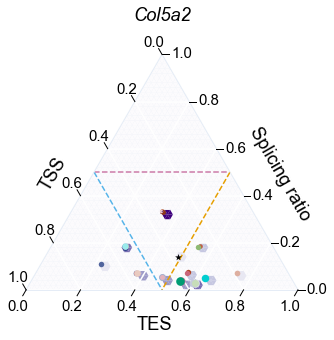

In [26]:
gene = 'Col5a2'
plot_sample_det_density_simplex(ca, gene, species='mouse')

In [45]:
df.head()

,Gene stable ID,Mouse gene stable ID,source_human,gid_human,n_tss_human,n_tes_human,n_ic_human,n_iso_human,splicing_ratio_human,tss_ratio_human,...,tss_ratio_mouse,tes_ratio_mouse,spl_ratio_mouse,sector_mouse,gname_mouse,sample_mouse,gene_tpm_mouse,biotype_category_mouse,sector_conserved,splicing_conserved
0,ENSG00000065135,ENSMUSG00000000001,obs_mm_major,ENSG00000065135,1.0,3.0,1.0,3.0,0.500000,0.222222,...,0.333333,0.333333,0.333333,simple,Gnai3,NaN,NaN,protein_coding,False,False
1,ENSG00000093009,ENSMUSG00000000028,obs_mm_major,ENSG00000093009,1.0,1.0,6.0,6.0,6.000000,0.125000,...,0.405405,0.270270,0.324324,mixed,Cdc45,NaN,NaN,protein_coding,False,False
2,ENSG00000102098,ENSMUSG00000000037,obs_mm_major,ENSG00000102098,1.0,1.0,2.0,2.0,2.000000,0.250000,...,0.365854,0.243902,0.390244,mixed,Scml2,NaN,NaN,protein_coding,True,False
3,ENSG00000141562,ENSMUSG00000000056,obs_mm_major,ENSG00000141562,2.0,2.0,8.0,10.0,4.000000,0.250000,...,0.230769,0.461538,0.307692,mixed,Narf,NaN,NaN,protein_coding,True,False
4,ENSG00000105971,ENSMUSG00000000058,obs_mm_major,ENSG00000105971,3.0,4.0,3.0,6.0,0.857143,0.381818,...,0.333333,0.333333,0.333333,simple,Cav2,NaN,NaN,protein_coding,False,False


,source_sample_mm_det_centroid,gid_sample_mm_det_centroid,n_tss_sample_mm_det_centroid,n_tes_sample_mm_det_centroid,n_ic_sample_mm_det_centroid,n_iso_sample_mm_det_centroid,splicing_ratio_sample_mm_det_centroid,tss_ratio_sample_mm_det_centroid,tes_ratio_sample_mm_det_centroid,spl_ratio_sample_mm_det_centroid,...,spl_ratio_sample_det_mouse_centroid,sector_sample_det_mouse_centroid,gname_sample_det_mouse_centroid,sample_sample_det_mouse_centroid,gene_tpm_sample_det_mouse_centroid,Mouse gene stable ID_sample_det_mouse_centroid,gid_stable_sample_det_mouse_centroid,biotype_sample_det_mouse_centroid,dist,z_score
0,sample_mm_det_centroid,ENSG00000112699,1.777778,1.777778,2.777778,2.777778,1.500000,0.332252,0.365427,0.302321,...,0.328526,mixed,Gmds,NaN,NaN,ENSMUSG00000038372,ENSMUSG00000038372,protein_coding,0.020545,-1.246395
1,sample_mm_det_centroid,ENSG00000112936,2.500000,3.000000,4.500000,6.000000,1.388889,0.352234,0.398625,0.249141,...,0.333333,simple,C7,NaN,NaN,ENSMUSG00000079105,ENSMUSG00000079105,protein_coding,0.068127,-0.577519
2,sample_mm_det_centroid,ENSG00000147650,1.888889,2.444444,3.111111,4.111111,1.499471,0.313136,0.410024,0.276839,...,0.306133,mixed,Lrp12,NaN,NaN,ENSMUSG00000022305,ENSMUSG00000022305,protein_coding,0.112779,0.050155
3,sample_mm_det_centroid,ENSG00000157593,2.111111,1.000000,6.333333,6.555556,4.018519,0.300077,0.144191,0.555732,...,0.577670,splicing,Slc35b2,NaN,NaN,ENSMUSG00000037089,ENSMUSG00000037089,protein_coding,0.155524,0.651041
4,sample_mm_det_centroid,ENSG00000157600,1.333333,2.000000,2.000000,3.000000,1.088889,0.303030,0.444444,0.252525,...,0.312139,mixed,Tmem164,NaN,NaN,ENSMUSG00000047045,ENSMUSG00000047045,protein_coding,0.082907,-0.369758
